# Galton Height dataset analysis

Dataset downloaded from [Harvard Dataverse](https://doi.org/10.7910/DVN/T0HSJ1)

<em>"This is the famous Galton data on the heights or parents and their children (i.e., where the term 'regression' comes from)."</em> <br>

"The concept of regression comes from genetics and was popularized by Sir Francis Galton during the late 19th century with the publication of Regression towards mediocrity in hereditary stature.[12] Galton observed that extreme characteristics (e.g., height) in parents are not passed on completely to their offspring. Rather, the characteristics in the offspring regress towards a mediocre point (a point which has since been identified as the mean). By measuring the heights of hundreds of people, he was able to quantify regression to the mean, and estimate the size of the effect. Galton wrote that, "the average regression of the offspring is a constant fraction of their respective mid-parental deviations". This means that the difference between a child and its parents for some characteristic is proportional to its parents' deviation from typical people in the population." [source](https://en.wikipedia.org/wiki/Regression_toward_the_mean)

The objective with this analysis is to explore a Linear Regression model over Probabilistic Programming.

### Dataset description:
* family: subset of family.
* father: height of the father in inches.
* mother: height of the mother in inches.
* gender: gender of the child for these father and mother.
* kids: number of kids the family has.
* male: 1 if child is male and 0 otherwise.
* female: 0 if child is female and 0 otherwise.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load dataset
df = pd.read_csv('data/galton-stata11.tab', sep='\t')
df.head()

,family,father,mother,gender,height,kids,male,female
0,1,78.5,67.0,M,73.2,4,1.0,0.0
1,1,78.5,67.0,F,69.2,4,0.0,1.0
2,1,78.5,67.0,F,69.0,4,0.0,1.0
3,1,78.5,67.0,F,69.0,4,0.0,1.0
4,2,75.5,66.5,M,73.5,4,1.0,0.0


As a matter of preference the heights in inches are converted to centimeters, as follows:

In [3]:
df[['father', 'mother', 'height']] = df[['father', 'mother', 'height']].apply(lambda x: round(x/0.39370, 2))
df.head()

,family,father,mother,gender,height,kids,male,female
0,1,199.39,170.18,M,185.93,4,1.0,0.0
1,1,199.39,170.18,F,175.77,4,0.0,1.0
2,1,199.39,170.18,F,175.26,4,0.0,1.0
3,1,199.39,170.18,F,175.26,4,0.0,1.0
4,2,191.77,168.91,M,186.69,4,1.0,0.0


## Dataset analysis
Performing first analysis on the dataset by:
* checking for missing data.
* visualising.
* adequating for further modeling.

In [4]:
# Checking missing data
df.isnull().any()

family    False
father    False
mother    False
gender    False
height    False
kids      False
male      False
female    False
dtype: bool

We can see from the table above there's no missing data in any column.

In [5]:
df.describe()

,father,mother,height,kids,male,female
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
mean,175.851492,162.774488,169.572316,6.135857,0.517817,0.482183
std,6.274480,5.859858,9.100671,2.685156,0.499961,0.499961
min,157.480000,147.320000,142.240000,1.000000,0.000000,0.000000
25%,172.720000,160.020000,162.560000,4.000000,0.000000,0.000000
50%,175.260000,162.560000,168.910000,6.000000,1.000000,0.000000
75%,180.340000,166.370000,177.040000,8.000000,1.000000,1.000000
max,199.390000,179.070000,200.660000,15.000000,1.000000,1.000000


[]

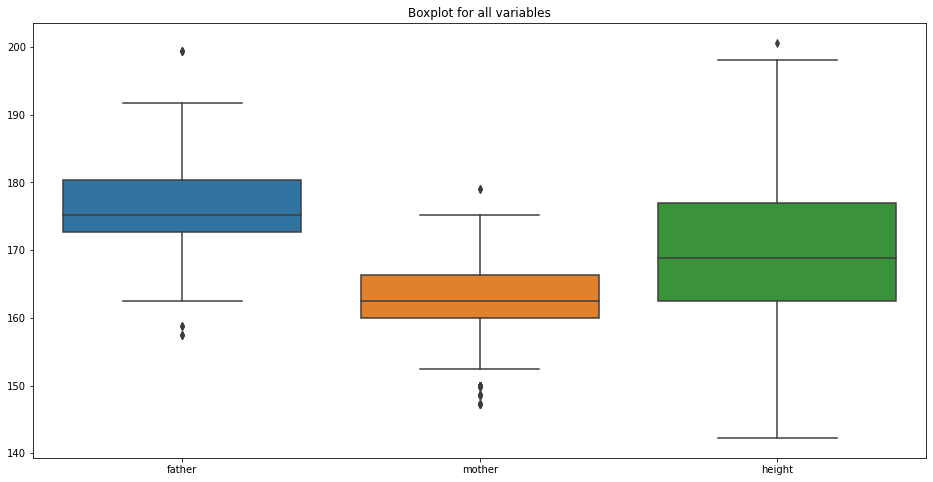

In [6]:
# showing the boxplot for all variables (except Date and Time)
plt.figure(figsize=(16,8))
sns.boxplot(data=df.loc[:, 'father':'height']).set_title("Boxplot for all variables")
plt.plot()

By the description of the data, according to the sample that Galton studied, fathers are, on average, `13 cm` taller than mothers. <br>

The boxplot shows that clearly and also the trend of children to have, on average, the height among the one of the parents.

We have a few outliers, however, they are not that far from the heights measured an shouldn't get any special attention.

To adequate better the data we'll put the gender information in one column only, as numerical data, and drop the separate 'male' and 'female' columns which are unecessary.

In [7]:
# create column gender
df['gender'] = df['female'].astype(int)

# drop columns 'male' and 'female'
df.drop(columns=['male', 'female'], inplace=True)

df.head()

,family,father,mother,gender,height,kids
0,1,199.39,170.18,0,185.93,4
1,1,199.39,170.18,1,175.77,4
2,1,199.39,170.18,1,175.26,4
3,1,199.39,170.18,1,175.26,4
4,2,191.77,168.91,0,186.69,4


To have a model based on a single predictor variable the average height of the parents will be used, as it's suggested by the original Galton's paper and that presented a hight correlation.  

In [8]:
df['mid_parents'] = (df['mother']+df['father'])/2
df.head()

,family,father,mother,gender,height,kids,mid_parents
0,1,199.39,170.18,0,185.93,4,184.785
1,1,199.39,170.18,1,175.77,4,184.785
2,1,199.39,170.18,1,175.26,4,184.785
3,1,199.39,170.18,1,175.26,4,184.785
4,2,191.77,168.91,0,186.69,4,180.340


From now on, on the column `gender` we have the identifiers as `0 for male` and `1 for female`.

[]

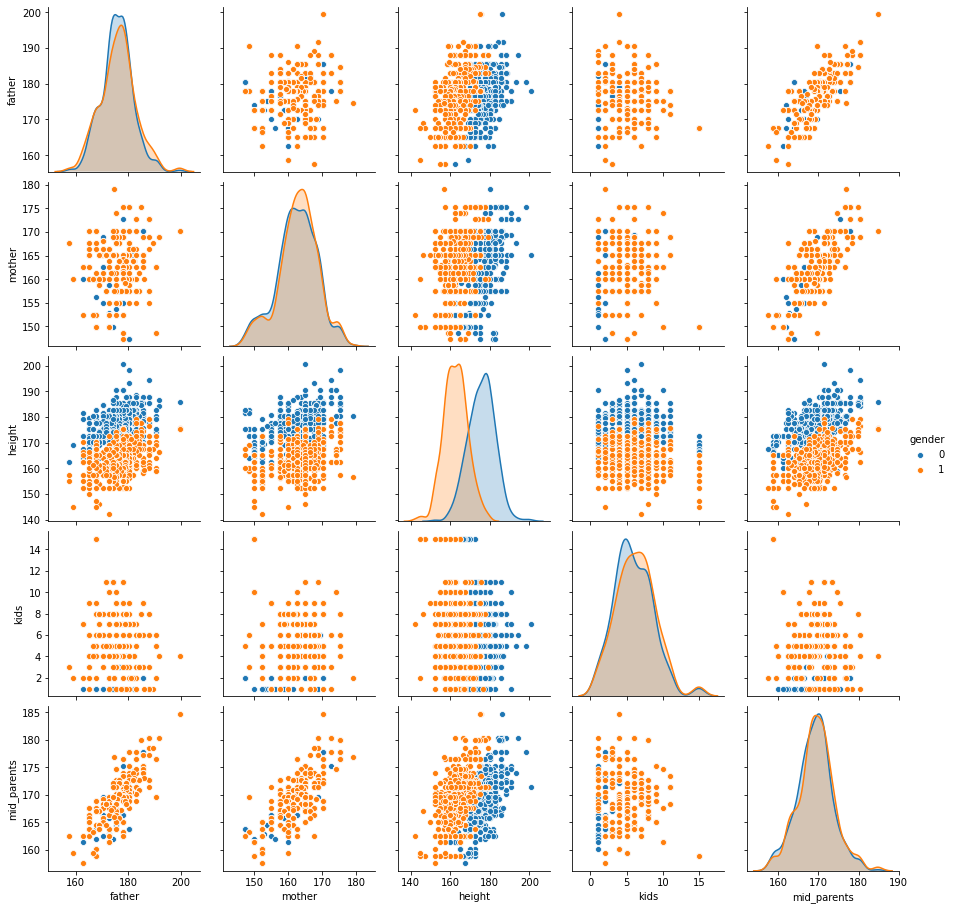

In [9]:
sns.pairplot(data=df, hue='gender')
plt.plot()

In [10]:
df.corr()['height']

father         0.275358
mother         0.201658
gender        -0.714258
height         1.000000
kids          -0.126909
mid_parents    0.327077
Name: height, dtype: float64

The pairwise relationship in the dataset shows some correlation of the height with the father and mother's heights and a higher correlation with the middle of parents height. It also seems to depend heavily on the gender.

## Bayesian predictive model - single variable linear regression

The Bayesian analysis will be carried out using the library [PyMC3](https://docs.pymc.io/) for probabilistic programming in Python. <br>
It employs a computational method to calculate Bayesian posteriors using gradient-based MCMC algorithms.

In [11]:
import pymc3 as pm
import arviz as az

To have a model based on a single predictor variable the average height of the parents will be used, as it's suggested by the original Galton's paper and that presented a high correlation.  

A linear model `a(x - x_mean) + b` was selected to fit the heights. 
The posterior is a Normal distribution with `mu`, a deterministic (not a distribution) linear function composed by the parameters `a` and `b`. It means that the posterior is a distribution where the parameter `mu` is a set lines for each point.  

The parameter `a` multiplies the midheight minus the average of midheights. It was selected a Exponential distribution with parameter `alpha`. To calculate the hyper-parameter `alpha` we use a rule of thumb of setting the exponential parameters equal to the inverse of the average of the count data. From the book <em> Probabilistic Programming
and Bayesian Methods for Hackers</em> - [Chapter 1](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb)<br>

The parameter `b` is the intercept parameter and is the height when a(x-x_mean) equals to zero. For the prior it was selected `150cm` as the mean for the height with `25cm` of standard deviation, considering that `95.5%` of the population is within `100cm` to `200cm`. 

In [12]:
samp_size = 4000
x_mean = df.mid_parents.mean()

with pm.Model() as model:
    #alpha = 1.0/df['mid_parents'].mean()
    #a = pm.Exponential('a', alpha)
    
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', mu=150, sd=25)
    
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    mu = pm.Deterministic('mu', a*(df['mid_parents'].values - x_mean) + b)
    
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df['height'].values)
    start = pm.find_MAP()

logp = -3,222.3, ||grad|| = 74.567: 100%|██████████| 39/39 [00:00<00:00, 3408.80it/s]           


In [13]:
with model:
    trace = pm.sample(samp_size, tune=2000, start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:05<00:00, 4690.71draws/s]


It's a good practice to discard the first samples as the model has not yet converged, called burn-in period.<em> Probabilistic Programming
and Bayesian Methods for Hackers</em> - [Chapter 3](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb)
In this case the burn-in period was defined as the first 1/4 of the samples and we'll use the rest 3/4 of the samples.

In [14]:
burned_trace = trace[int(samp_size/4):]

Also it's important to take a look at the some possible regression priors, to make sure they make sense for the model.

In [15]:
with model:
    priors = pm.sample_prior_predictive()

Text(0.5, 1.0, 'Prior regression lines')

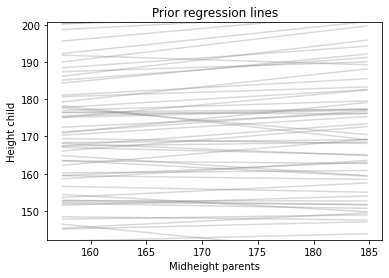

In [16]:
x = np.linspace(df['mid_parents'].min(), df['mid_parents'].max(), 100)

for a, b in zip(priors['a'][50:], priors['b'][50:]):
    y = a*x + b
    plt.plot(x, y, color='gray', alpha=0.3)

plt.ylim(df['height'].min(), df['height'].max())
plt.xlabel('Midheight parents')
plt.ylabel('Height child')
plt.title('Prior regression lines')

The priors seem ok.

Plot traces for all parameters except for mu as there's a mu for each point.

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

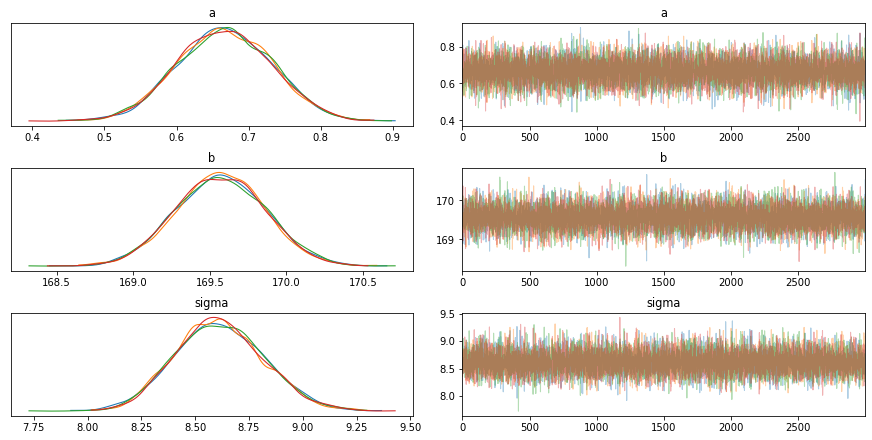

In [18]:
varnames = ["~mu"]
az.plot_trace(burned_trace, varnames)

Above we can see the trace of the 4 chains for each parameter, and that all 4 converged (also stated after sampling). There're no odd patterns.<br>

Bellow, the posterior distributions for all parameters (except mu).

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'b'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

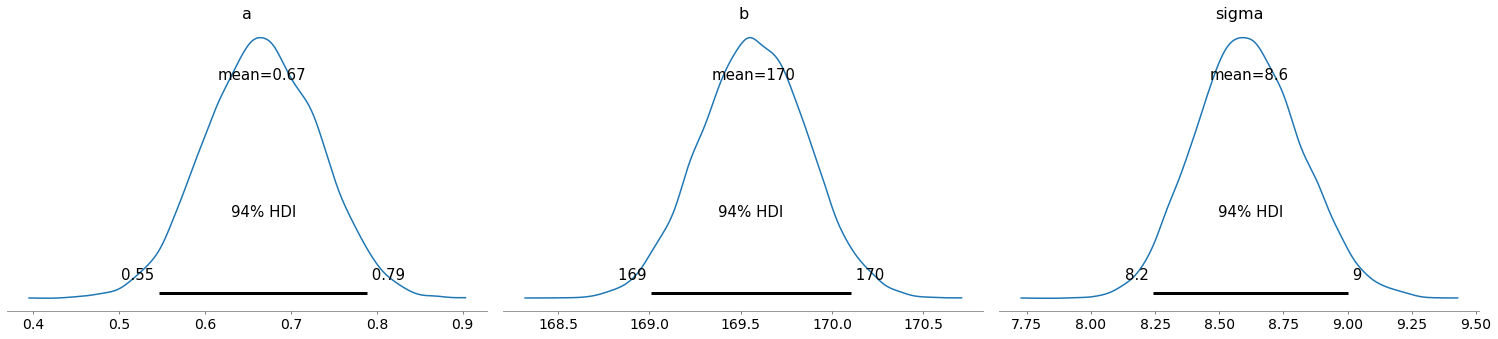

In [19]:
az.plot_posterior(burned_trace, varnames)

We selected 3 distributions to see as histograms.

It's important to notice that the horizontal line in each distribution corresponds to the `94% Highest Density Interval` also known as `Credible Interval`. This is not iqual to the `Confidence Interval` of frequentist analysis, actually there's a point of difference between these two types of analysis.
The `94% HDI` means "there is a 94% chance that the parameter of interest is contained between this interval"

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'b'}>], dtype=object)

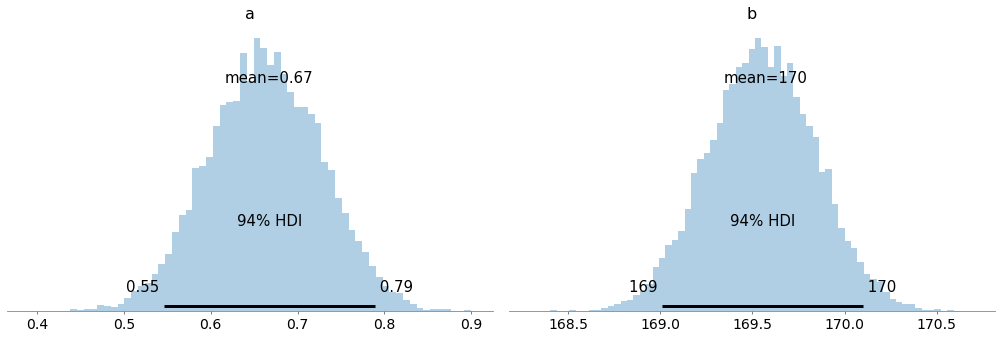

In [20]:
az.plot_posterior(burned_trace, var_names=['a','b'], kind='hist')

Summary of the sampled data, except for mu, rounded to 2 decimals.

In [21]:
az.summary(burned_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.67,0.07,0.55,0.79
b,169.57,0.29,169.01,170.10
sigma,8.61,0.21,8.24,9.00


mu_pred is a set of distributions one set for each value of mu, so there're 6000 (1500 interactions x 4 chains) for each point.

In [22]:
mu_pred = burned_trace['mu']
print(mu_pred.shape)
print(burned_trace)

(12000, 898)
<MultiTrace: 4 chains, 3000 iterations, 5 variables>


Each of the 898 index in the mu_pred is an array of distributions points.

<AxesSubplot:>

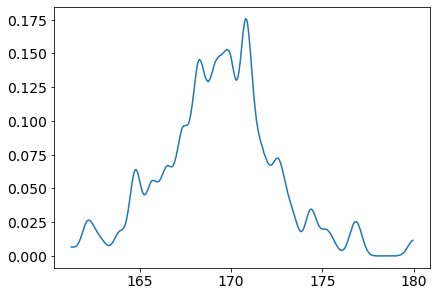

In [23]:
az.plot_kde(mu_pred[898])

An array of means for each mu, corresponding to each child height at each midheight parents points, is calculated bellow and stored in `mu_mean`.

In [24]:
mu_mean = mu_pred.mean(0)

The plot bellow shows a scatterplot of the height data, the mean for each pair of heights is represented by a thin black line, and the shade `HDI` of `89%` for the mean (in orange).

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


[]

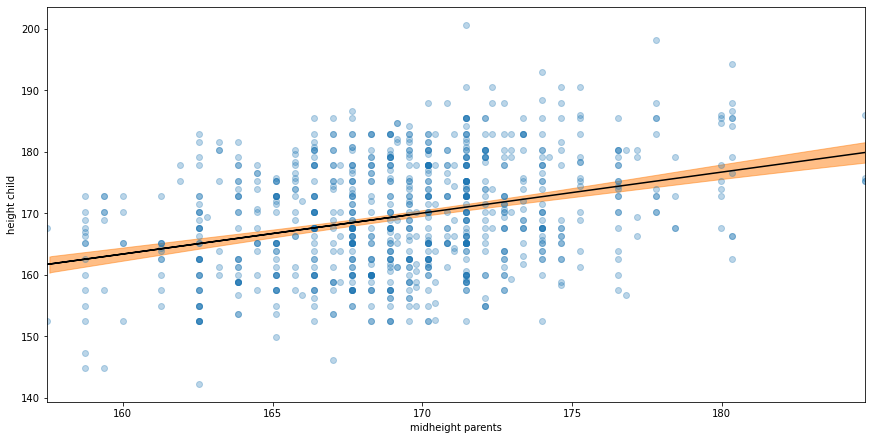

In [25]:
az.plot_hdi(df.mid_parents, mu_pred, hdi_prob=0.89, figsize=(12,6))
plt.scatter(df.mid_parents, df.height, alpha=0.3)
plt.plot(df.mid_parents, mu_mean, color='black')
plt.xlabel('midheight parents')
plt.ylabel('height child')
plt.xlim(df.mid_parents.min(), df.mid_parents.max())
plt.plot()

Sampling children height data from the posterior.

In [26]:
with model:
    height_pred = pm.sample_posterior_predictive(trace=burned_trace, vars=[height], size=200)

100%|██████████| 12000/12000 [01:02<00:00, 192.56it/s]


In addition to the elements described on the previous plot, this one includes a wider shaded region that represents where the model expects to find 89% of heights of children in the given population at each parent's midheight.

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/base.py:153: UserWarning: More chains (12000) than draws (200). Passed array should have shape (chains, draws, *shape)
  UserWarning,


[]

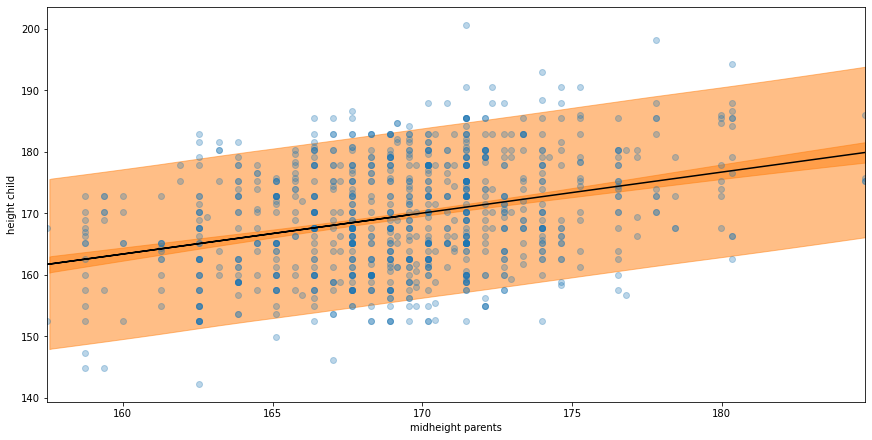

In [27]:
ax = az.plot_hdi(df.mid_parents, mu_pred, hdi_prob=0.89, figsize=(12,6))
az.plot_hdi(df.mid_parents, height_pred['height'], ax=ax, hdi_prob=0.89, figsize=(12,6))
plt.scatter(df.mid_parents, df.height, alpha=0.3)
plt.plot(df.mid_parents, mu_mean, color='black')
plt.xlabel('midheight parents')
plt.ylabel('height child')
plt.xlim(df.mid_parents.min(), df.mid_parents.max())
plt.plot()

---

---

In [ ]:
%load_ext watermark
%watermark -iv -v -nuw